In [362]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [363]:
### 시각화를 위한 라이브러리
# - 파이썬 시각화에서 가장 기본적인 시각화 라이브러리
import matplotlib.pyplot as plt

### 한글처리
from matplotlib import font_manager, rc

### 운영체제 확인 라이브러리
import platform

### 시각화 시 마이너스(-, 음수) 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

### OS별 한글처리
# - 윈도우 운영체게
if platform.system() == "Windows" :
    # path = "c:/Windows/Fonts/malgun.ttf"
    # font_name = font_manager.FontProperties(fname=path).get_name()
    # rc("font", family = font_name)
    
    ### 또는 아래처럼 한줄로도 가능 (아래 한글처리를 주로 사용합니다.)
    plt.rc("font", family = "Malgun Gothic")

# - Mac 운영체제
elif platform.system() == "Darwin" :
    rc("font", family = "AppleGothic")
    
else :
    print("넌 누구?")

In [364]:
labeled = pd.read_csv("./dataset/labeled_data.csv")

In [365]:
labeled_cn7 = labeled[(labeled["PART_NAME"] == "CN7 W/S SIDE MLD'G RH") |(labeled["PART_NAME"] == "CN7 W/S SIDE MLD'G LH")]

In [366]:
labeled_cn7 = labeled_cn7.drop(columns=["_id", "TimeStamp","PART_FACT_PLAN_DATE", "Reason", "PART_FACT_SERIAL", "PART_NAME",
               "EQUIP_NAME", "EQUIP_CD", "Switch_Over_Position", "Mold_Temperature_1","Mold_Temperature_2","Mold_Temperature_5",
                "Mold_Temperature_6", "Mold_Temperature_7","Mold_Temperature_8","Mold_Temperature_9","Mold_Temperature_10",
               "Mold_Temperature_11","Mold_Temperature_12","Barrel_Temperature_7"])

In [367]:
labeled_cn7["PassOrFail"] = labeled_cn7["PassOrFail"].replace('Y',1).replace('N',0)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15144\3829480872.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labeled_cn7["PassOrFail"] = labeled_cn7["PassOrFail"].replace('Y',1).replace('N',0)


In [368]:
### Clamp_Open_Position에서 눈에띄게 낮은 값들 제거
cn7 = labeled_cn7[labeled_cn7["Clamp_Open_Position"]>=200] 

In [369]:
cn7 = cn7.drop(columns=["Clamp_Open_Position"])

In [370]:
def remove_outliers(df, column):
    # 1사분위수(Q1)와 3사분위수(Q3) 계산
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # IQR 계산
    IQR = Q3 - Q1
    
    # 이상치 범위 설정
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 이상치 제거
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return filtered_df


col_list = [ 'Injection_Time', 'Filling_Time', 'Plasticizing_Time',
           'Cycle_Time', 'Clamp_Close_Time', 'Cushion_Position',
           'Plasticizing_Position', 'Max_Injection_Speed',
           'Max_Screw_RPM', 'Average_Screw_RPM', 'Max_Injection_Pressure',
           'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
           'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
           'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
           'Barrel_Temperature_6', 'Hopper_Temperature']

tmp = cn7.copy()

for col in col_list:
    tmp = remove_outliers(tmp, col)

In [371]:
cn7_Y = cn7[cn7["PassOrFail"]==1].copy()
print("CN7의 양품 개수:", len(cn7_Y))
cn7_N = cn7[cn7["PassOrFail"]==0].copy()
print("CN7의 불량 개수:", len(cn7_N))

CN7의 양품 개수: 6661
CN7의 불량 개수: 39


In [372]:
tmp1 = cn7_Y.copy()

In [373]:
tmp1 = remove_outliers(tmp1, "Injection_Time")
tmp1 = remove_outliers(tmp1, "Plasticizing_Time")
tmp1 = remove_outliers(tmp1, "Cycle_Time")
tmp1 = remove_outliers(tmp1, "Max_Injection_Speed")
tmp1 = remove_outliers(tmp1, "Mold_Temperature_3")

In [374]:
cn7_pass_removed = tmp1.copy()
cn7_pass_removed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6534 entries, 0 to 7995
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassOrFail                6534 non-null   int64  
 1   Injection_Time            6534 non-null   float64
 2   Filling_Time              6534 non-null   float64
 3   Plasticizing_Time         6534 non-null   float64
 4   Cycle_Time                6534 non-null   float64
 5   Clamp_Close_Time          6534 non-null   float64
 6   Cushion_Position          6534 non-null   float64
 7   Plasticizing_Position     6534 non-null   float64
 8   Max_Injection_Speed       6534 non-null   float64
 9   Max_Screw_RPM             6534 non-null   float64
 10  Average_Screw_RPM         6534 non-null   float64
 11  Max_Injection_Pressure    6534 non-null   float64
 12  Max_Switch_Over_Pressure  6534 non-null   float64
 13  Max_Back_Pressure         6534 non-null   float64
 14  Average_Back_

In [375]:
cn7_removed = pd.concat([cn7_pass_removed, cn7_N], ignore_index=True)
cn7_removed["PassOrFail"].value_counts()

PassOrFail
1    6534
0      39
Name: count, dtype: int64

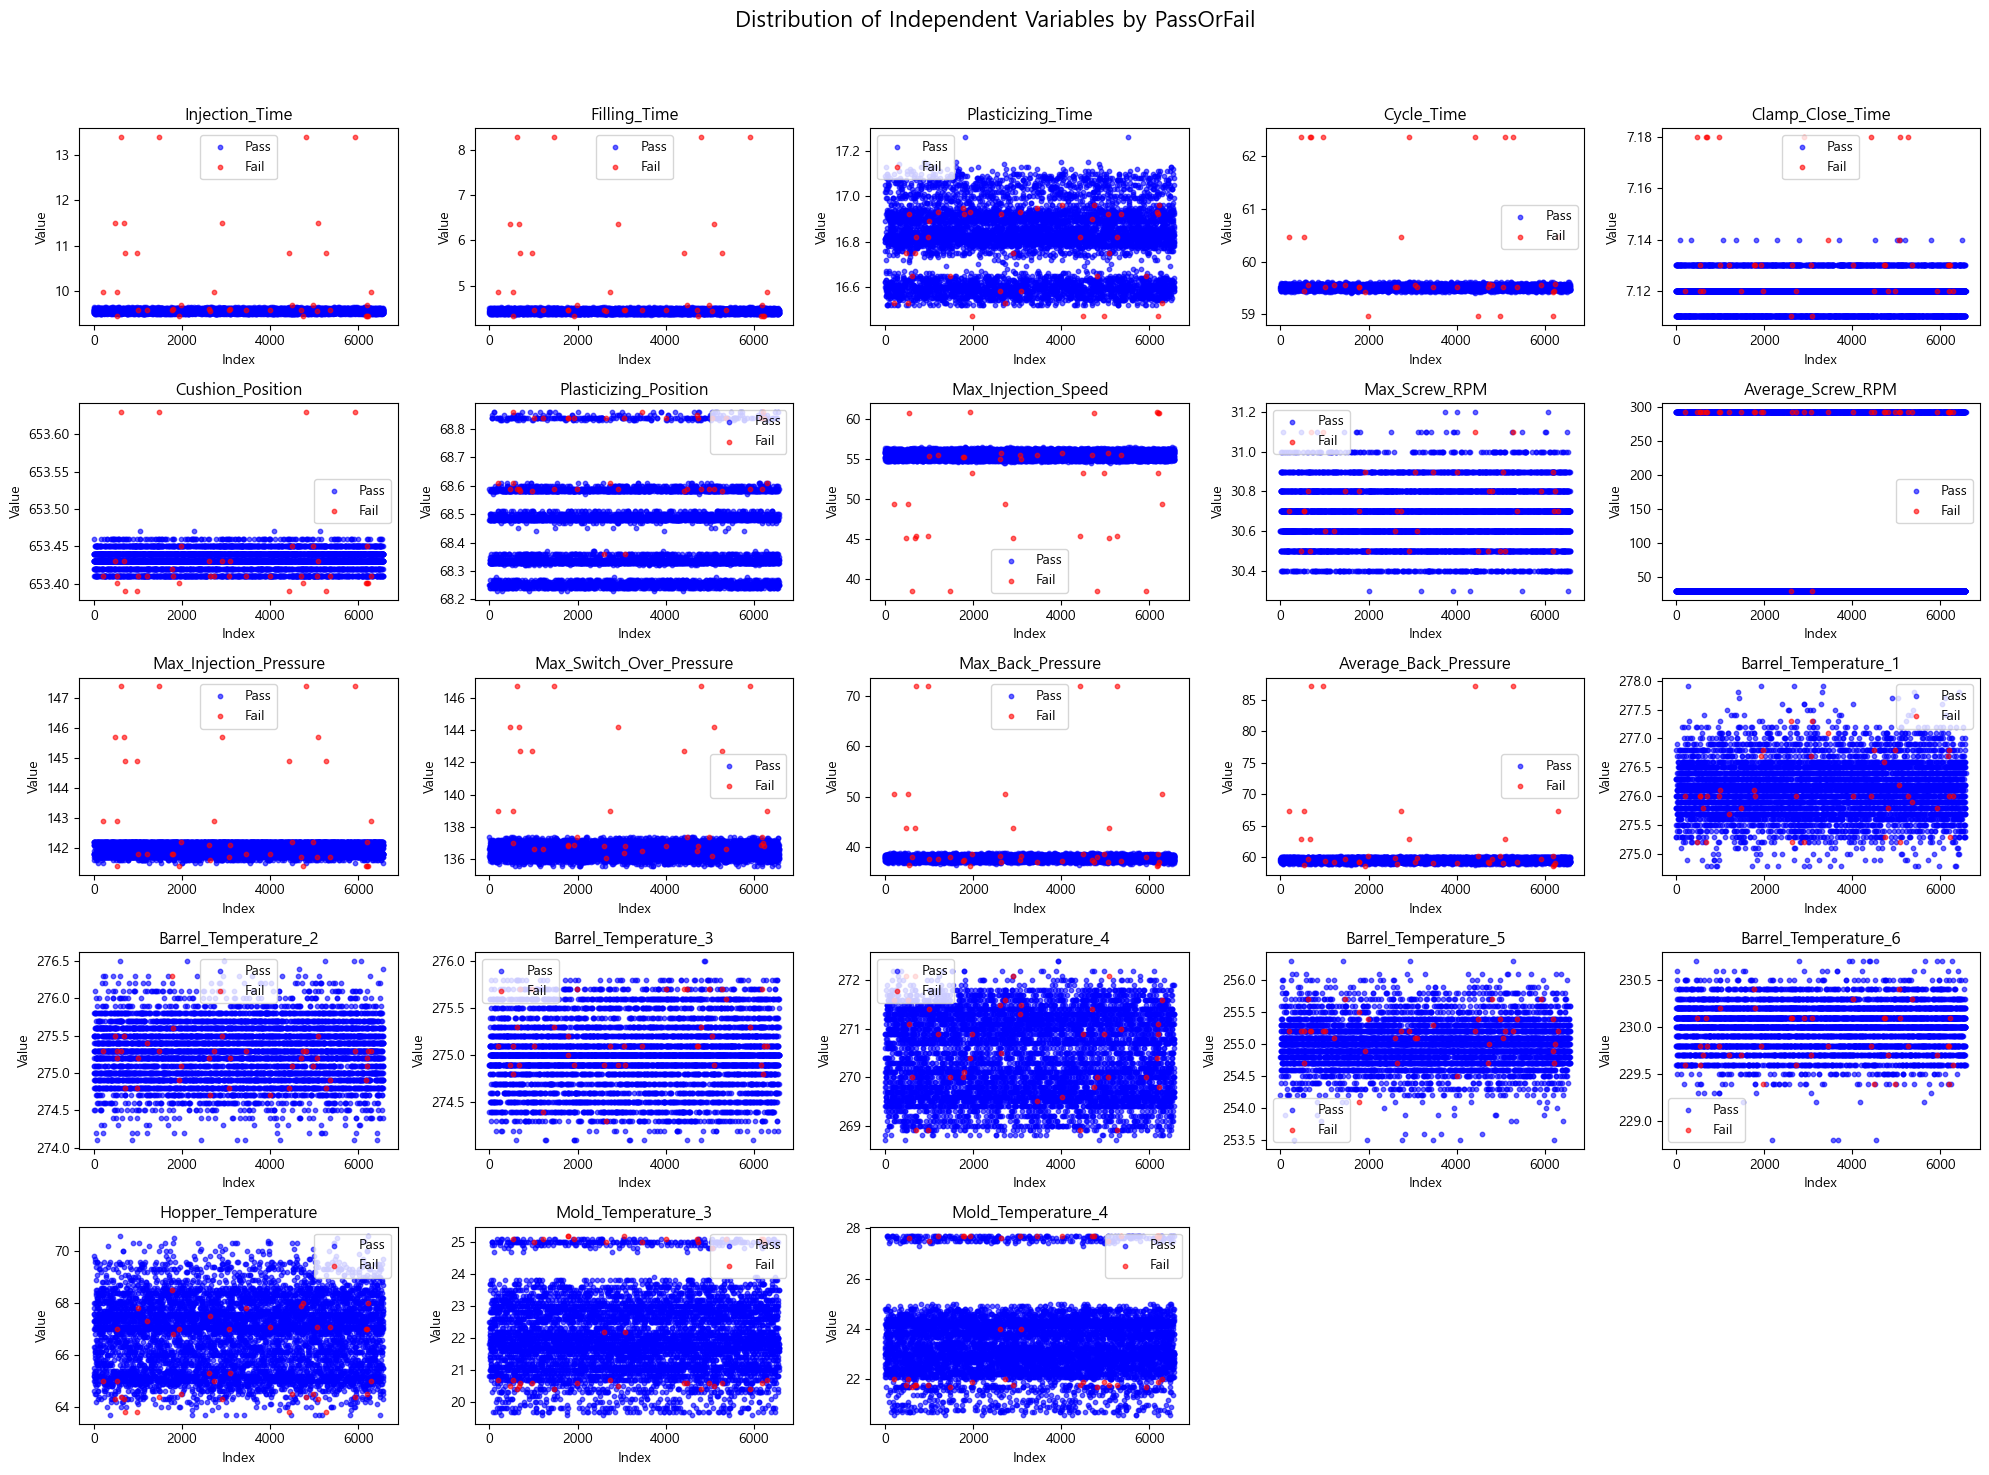

In [376]:
# 독립 변수와 종속 변수 분리
cn7_removed_shuffled = cn7_removed.sample(frac=1, random_state=42).reset_index(drop=True)

y = cn7_removed_shuffled["PassOrFail"]
X = cn7_removed_shuffled.drop(columns=["PassOrFail"])

# 그래프 설정
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()
fig.suptitle("Distribution of Independent Variables by PassOrFail", fontsize=16)

# 독립 변수별 산점도 생성
for i, column in enumerate(X.columns):
    ax = axes[i]
    ax.scatter(X.index[y == 1], X[column][y == 1], label="Pass", color="blue", alpha=0.6, s=10)
    ax.scatter(X.index[y == 0], X[column][y == 0], label="Fail", color="red", alpha=0.6, s=10)
    ax.set_title(column)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()

# 빈 그래프 제거
for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [377]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


# 독립변수 종속변수 분리 
y = cn7_removed["PassOrFail"]
X = cn7_removed.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled=ss.transform(X_test)

model = ExtraTreesClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}

# 평가 지표를 데이터프레임으로 변환
metrics_df = pd.DataFrame([metrics])

# 혼돈 행렬 계산 및 데이터프레임 변환
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# 평가지표와 혼돈 행렬 결합
combined_df = pd.concat([metrics_df.reset_index(drop=True), cm_df], axis=1)

# 결과 출력
combined_df

,Accuracy,Precision,Recall,F1 Score,Predicted 0,Predicted 1
0,0.996957,0.997959,0.998979,0.998469,NaN,NaN
Actual 0,NaN,NaN,NaN,NaN,10.0,4.0
Actual 1,NaN,NaN,NaN,NaN,2.0,1956.0


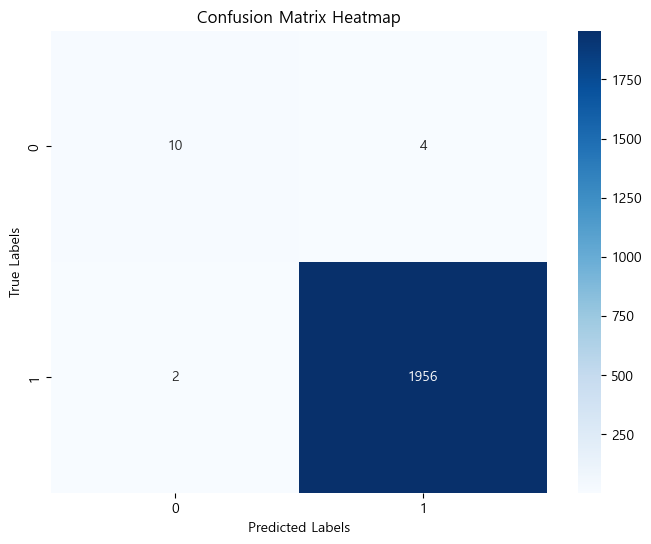

In [378]:
from sklearn.metrics import confusion_matrix
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [379]:
cn7_removed = cn7_removed.drop(columns = ["Filling_Time", "Average_Back_Pressure", "Mold_Temperature_3", "Max_Injection_Pressure",
                                          "Plasticizing_Time", "Max_Injection_Speed"])

In [380]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# 독립변수 종속변수 분리 
y = cn7_removed["PassOrFail"]
X = cn7_removed.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled=ss.transform(X_test)

model = ExtraTreesClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}

# 평가 지표를 데이터프레임으로 변환
metrics_df = pd.DataFrame([metrics])

# 혼돈 행렬 계산 및 데이터프레임 변환
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# 평가지표와 혼돈 행렬 결합
combined_df = pd.concat([metrics_df.reset_index(drop=True), cm_df], axis=1)

# 결과 출력
combined_df

,Accuracy,Precision,Recall,F1 Score,Predicted 0,Predicted 1
0,0.996957,0.997959,0.998979,0.998469,NaN,NaN
Actual 0,NaN,NaN,NaN,NaN,10.0,4.0
Actual 1,NaN,NaN,NaN,NaN,2.0,1956.0


In [381]:
grid_df["파라미터"][1]

"{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}"

In [382]:
model = ExtraTreesClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50)

Confusion Matrix Category Counts:
TP    1956
TN      10
FP       4
FN       2
Name: count, dtype: int64


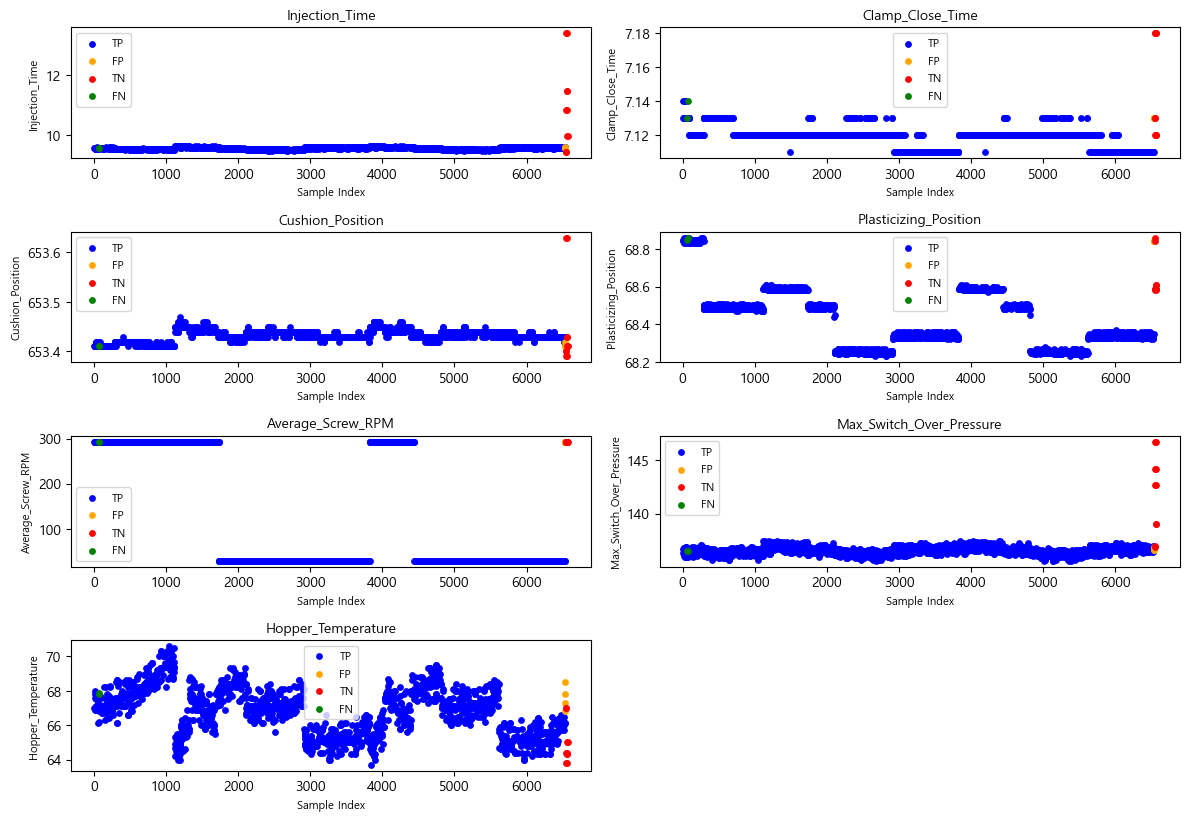

In [383]:
df = pd.DataFrame(cn7_removed_temp2)

# 독립변수 종속변수 분리 
y = cn7_removed_temp2["PassOrFail"]
X = cn7_removed_temp2.drop(columns=["PassOrFail"])


# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled=ss.transform(X_test)

model = model = ExtraTreesClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
# 혼돈 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 각 샘플에 대해 TN/FP/FN/TP 할당 함수 정의
def assign_confusion_category(y_true, y_pred):
    categories = []
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label == 0 and pred_label == 0:
            categories.append("TN") # True Negative
        elif true_label == 0 and pred_label == 1:
            categories.append("FP") # False Positive
        elif true_label == 1 and pred_label == 0:
            categories.append("FN") # False Negative
        elif true_label == 1 and pred_label == 1:
            categories.append("TP") # True Positive
    return categories

# 카테고리 할당
categories = assign_confusion_category(y_test.values, y_pred)

# 테스트 데이터에 카테고리 추가
X_test_with_categories = X_test.copy()
X_test_with_categories["Category"] = categories

# TN/FP/FN/TP 개수 계산
category_counts = pd.Series(categories).value_counts()

# 결과 출력 (카테고리 개수)
print("Confusion Matrix Category Counts:")
print(category_counts)

# 산점도 시각화
plt.figure(figsize=(12,12))
colors = {"TP": "blue", "FP": "orange", "TN": "red", "FN": "green"}

for i, column in enumerate(X_test.columns):
    plt.subplot(6, int(np.ceil(len(X_test.columns) / 5)), i+1)
    for category in colors.keys():
        subset = X_test_with_categories[X_test_with_categories["Category"] == category]
        plt.scatter(
            subset.index,
            subset[column],
            label=category,
            color=colors[category],
            s=15 # 점 크기 조정 (작게 설정)
        )
    plt.title(f"{column}", fontsize=10) # 제목 글씨 크기 조정
    plt.xlabel("Sample Index", fontsize=8) # x축 글씨 크기 조정
    plt.ylabel(column, fontsize=8) # y축 글씨 크기 조정
    plt.legend(fontsize=8) # 범례 글씨 크기 조정

plt.tight_layout()
plt.show()

In [384]:
cn7_removed_temp = cn7_removed.drop(columns = ["Max_Screw_RPM", "Max_Back_Pressure", "Barrel_Temperature_1", 
                                          "Barrel_Temperature_2","Barrel_Temperature_3", "Barrel_Temperature_4",
                                          "Barrel_Temperature_5", "Barrel_Temperature_6", "Mold_Temperature_4"])

In [385]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# 독립변수 종속변수 분리 
y = cn7_removed_temp["PassOrFail"]
X = cn7_removed_temp.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled=ss.transform(X_test)

model = ExtraTreesClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}

# 평가 지표를 데이터프레임으로 변환
metrics_df = pd.DataFrame([metrics])

# 혼돈 행렬 계산 및 데이터프레임 변환
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# 평가지표와 혼돈 행렬 결합
combined_df = pd.concat([metrics_df.reset_index(drop=True), cm_df], axis=1)

# 결과 출력
combined_df

,Accuracy,Precision,Recall,F1 Score,Predicted 0,Predicted 1
0,0.996957,0.997959,0.998979,0.998469,NaN,NaN
Actual 0,NaN,NaN,NaN,NaN,10.0,4.0
Actual 1,NaN,NaN,NaN,NaN,2.0,1956.0


In [386]:
cn7_removed_temp1 = cn7_removed_temp.drop(columns = ["Cushion_Position"])

In [387]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# 독립변수 종속변수 분리 
y = cn7_removed_temp1["PassOrFail"]
X = cn7_removed_temp1.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled=ss.transform(X_test)

model = ExtraTreesClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}

# 평가 지표를 데이터프레임으로 변환
metrics_df = pd.DataFrame([metrics])

# 혼돈 행렬 계산 및 데이터프레임 변환
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# 평가지표와 혼돈 행렬 결합
combined_df = pd.concat([metrics_df.reset_index(drop=True), cm_df], axis=1)

# 결과 출력
combined_df

,Accuracy,Precision,Recall,F1 Score,Predicted 0,Predicted 1
0,0.996957,0.997959,0.998979,0.998469,NaN,NaN
Actual 0,NaN,NaN,NaN,NaN,10.0,4.0
Actual 1,NaN,NaN,NaN,NaN,2.0,1956.0


In [388]:
cn7_removed_temp2 = cn7_removed_temp.drop(columns = ["Cycle_Time"])

In [389]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# 독립변수 종속변수 분리 
y = cn7_removed_temp2["PassOrFail"]
X = cn7_removed_temp2.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled=ss.transform(X_test)

model = model = ExtraTreesClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}

# 평가 지표를 데이터프레임으로 변환
metrics_df = pd.DataFrame([metrics])

# 혼돈 행렬 계산 및 데이터프레임 변환
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# 평가지표와 혼돈 행렬 결합
combined_df = pd.concat([metrics_df.reset_index(drop=True), cm_df], axis=1)

# 결과 출력
combined_df

,Accuracy,Precision,Recall,F1 Score,Predicted 0,Predicted 1
0,0.996957,0.997959,0.998979,0.998469,NaN,NaN
Actual 0,NaN,NaN,NaN,NaN,10.0,4.0
Actual 1,NaN,NaN,NaN,NaN,2.0,1956.0


Confusion Matrix Category Counts:
TP    1961
TN       8
FP       2
FN       1
Name: count, dtype: int64


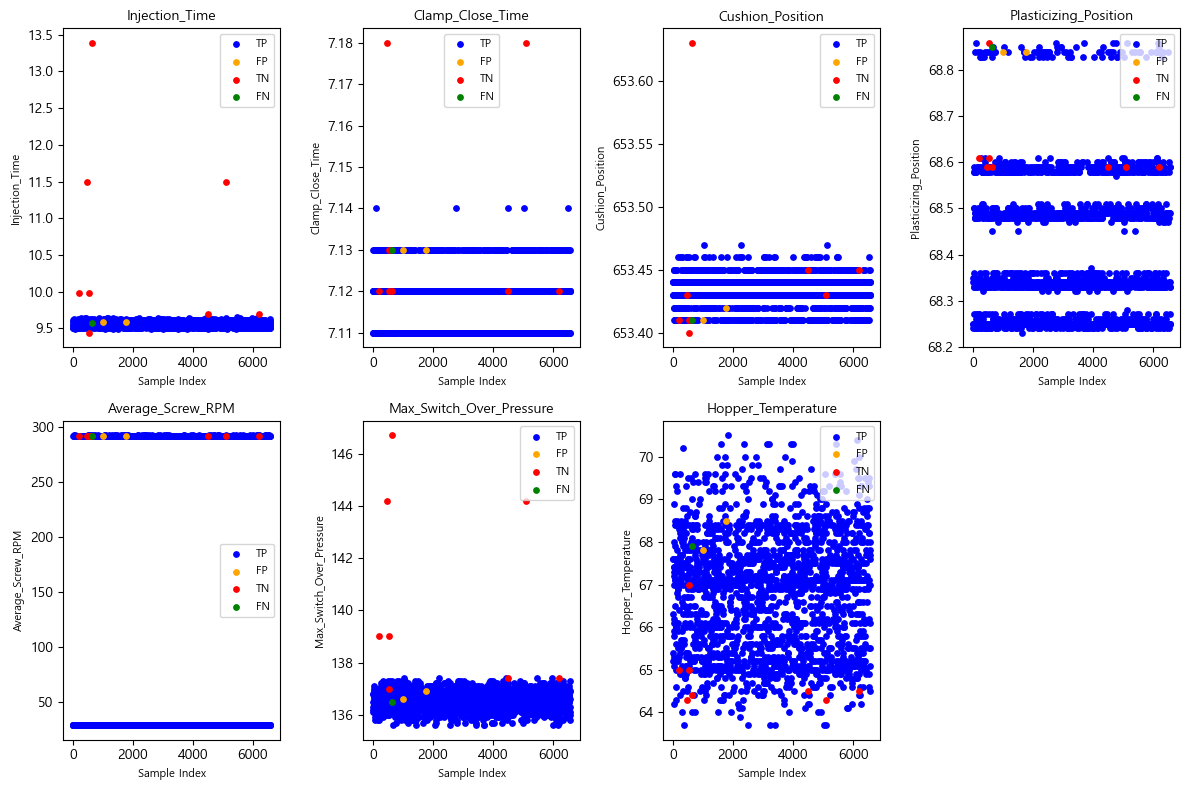

In [399]:
df = pd.DataFrame(cn7_removed_temp2)
cn7_removed_shuffled = cn7_removed_temp2.sample(frac=1, random_state=42).reset_index(drop=True)

# 독립변수 종속변수 분리 
y = cn7_removed_shuffled["PassOrFail"]
X = cn7_removed_shuffled.drop(columns=["PassOrFail"])


# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled=ss.transform(X_test)

model = model = ExtraTreesClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
# 혼돈 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 각 샘플에 대해 TN/FP/FN/TP 할당 함수 정의
def assign_confusion_category(y_true, y_pred):
    categories = []
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label == 0 and pred_label == 0:
            categories.append("TN") # True Negative
        elif true_label == 0 and pred_label == 1:
            categories.append("FP") # False Positive
        elif true_label == 1 and pred_label == 0:
            categories.append("FN") # False Negative
        elif true_label == 1 and pred_label == 1:
            categories.append("TP") # True Positive
    return categories

# 카테고리 할당
categories = assign_confusion_category(y_test.values, y_pred)

# 테스트 데이터에 카테고리 추가
X_test_with_categories = X_test.copy()
X_test_with_categories["Category"] = categories

# TN/FP/FN/TP 개수 계산
category_counts = pd.Series(categories).value_counts()

# 결과 출력 (카테고리 개수)
print("Confusion Matrix Category Counts:")
print(category_counts)

# 산점도 시각화
plt.figure(figsize=(12, 8))
colors = {"TP": "blue", "FP": "orange", "TN": "red", "FN": "green"}

for i, column in enumerate(X_test.columns):
    plt.subplot(2, int(np.ceil(len(X_test.columns) / 2)), i + 1)
    for category in colors.keys():
        subset = X_test_with_categories[X_test_with_categories["Category"] == category]
        plt.scatter(
            subset.index,
            subset[column],
            label=category,
            color=colors[category],
            s=15 # 점 크기 조정 (작게 설정)
        )
    plt.title(f"{column}", fontsize=10) # 제목 글씨 크기 조정
    plt.xlabel("Sample Index", fontsize=8) # x축 글씨 크기 조정
    plt.ylabel(column, fontsize=8) # y축 글씨 크기 조정
    plt.legend(fontsize=8) # 범례 글씨 크기 조정

plt.tight_layout()
plt.show()

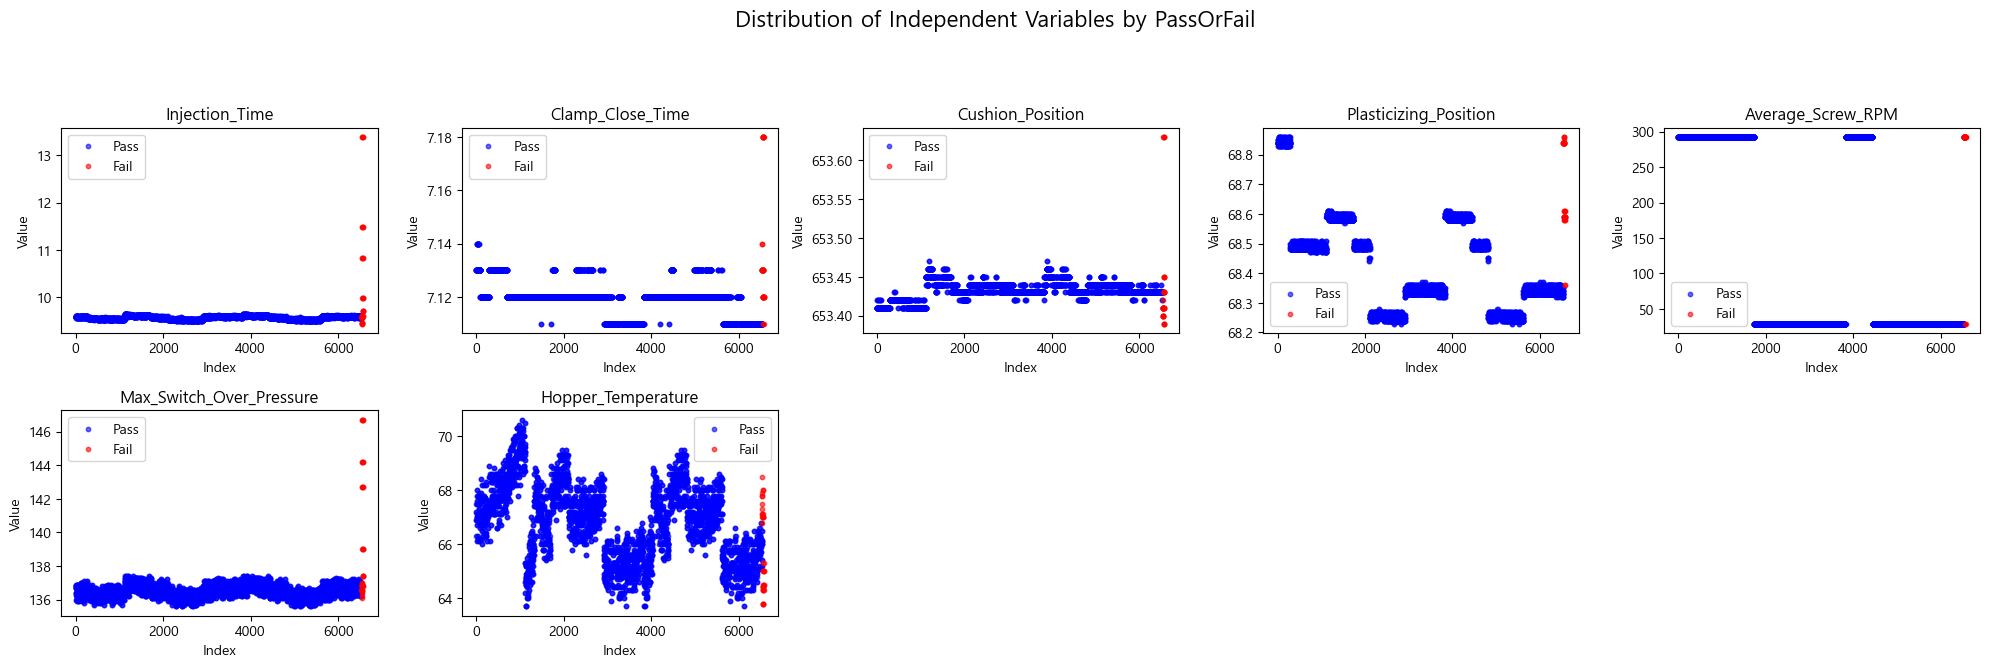

In [391]:
# 독립 변수와 종속 변수 분리
y = cn7_removed_temp2["PassOrFail"]
X = cn7_removed_temp2.drop(columns=["PassOrFail"])

# 그래프 설정
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()
fig.suptitle("Distribution of Independent Variables by PassOrFail", fontsize=16)

# 독립 변수별 산점도 생성
for i, column in enumerate(X.columns):
    ax = axes[i]
    ax.scatter(X.index[y == 1], X[column][y == 1], label="Pass", color="blue", alpha=0.6, s=10)
    ax.scatter(X.index[y == 0], X[column][y == 0], label="Fail", color="red", alpha=0.6, s=10)
    ax.set_title(column)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()

# 빈 그래프 제거
for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

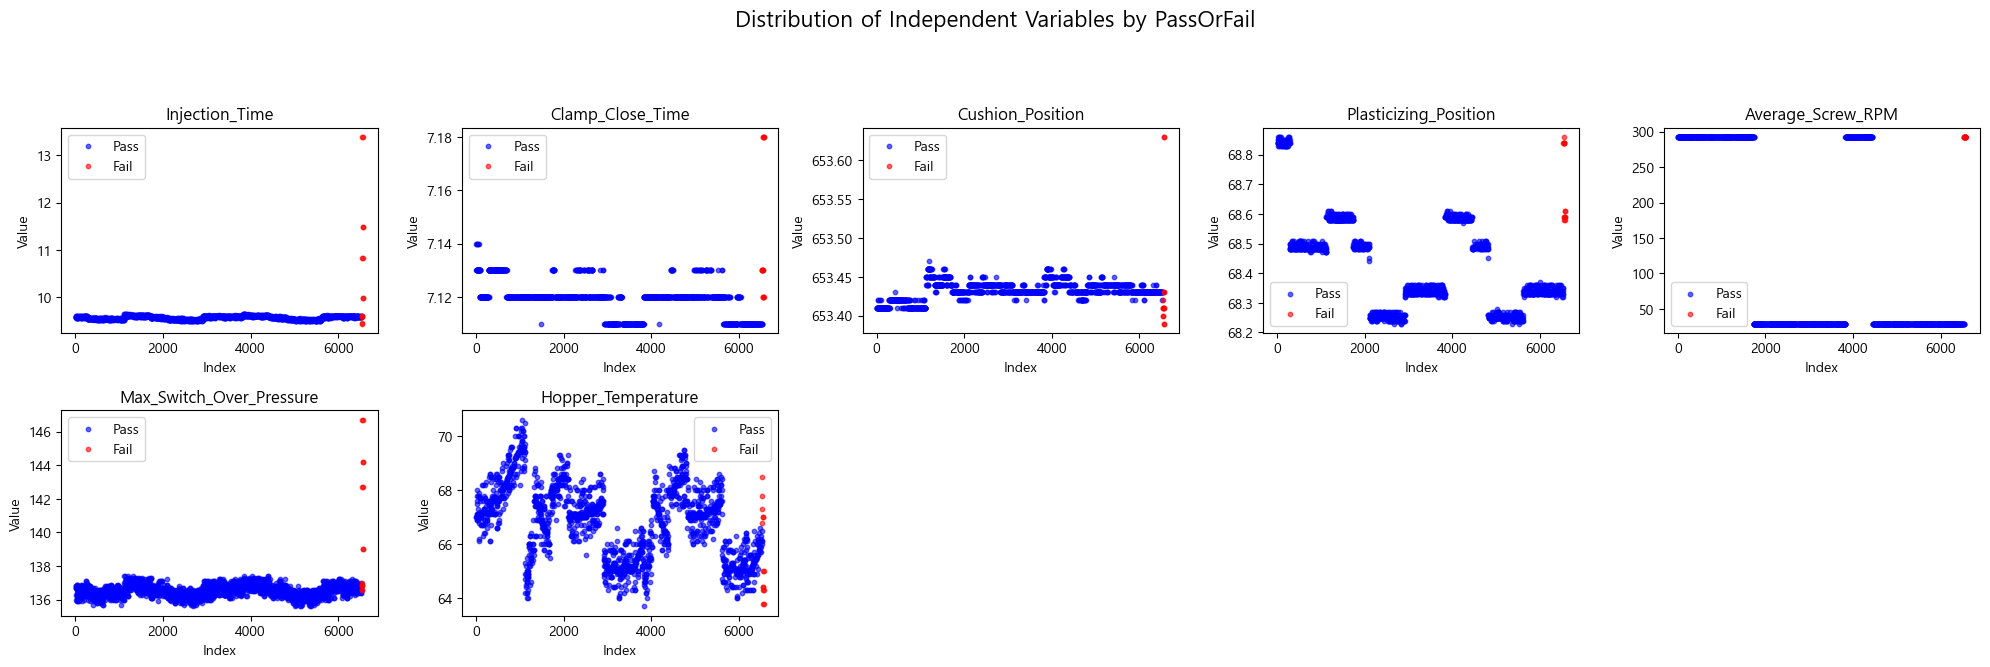

In [392]:
# 독립 변수와 종속 변수 분리
X = X_test
y = y_test

# 그래프 설정
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 15))
axes = axes.flatten()
fig.suptitle("Distribution of Independent Variables by PassOrFail", fontsize=16)

# 독립 변수별 산점도 생성
for i, column in enumerate(X.columns):
    ax = axes[i]
    ax.scatter(X.index[y == 1], X[column][y == 1], label="Pass", color="blue", alpha=0.6, s=10)
    ax.scatter(X.index[y == 0], X[column][y == 0], label="Fail", color="red", alpha=0.6, s=10)
    ax.set_title(column)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()

# 빈 그래프 제거
for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [393]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

y = cn7_removed_temp["PassOrFail"]
X = cn7_removed_temp.drop(columns=["PassOrFail"])

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1. 전체 모델 학습 및 성능 측정
model = ExtraTreesClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50)
model.fit(X_train, y_train)
baseline_accuracy = accuracy_score(y_test, model.predict(X_test))
print(f"Baseline Accuracy: {baseline_accuracy}")

# 2. 각 변수 제거 후 성능 측정
importances = []
for col in X.columns:
    # 해당 변수를 제거한 데이터셋 생성
    X_train_dropped = X_train.drop(columns=[col])
    X_test_dropped = X_test.drop(columns=[col])
    
    # 모델 재학습 및 성능 측정
    model.fit(X_train_dropped, y_train)
    dropped_accuracy = accuracy_score(y_test, model.predict(X_test_dropped))
    
    # 변수 중요도 계산 (성능 하락량)
    importance = baseline_accuracy - dropped_accuracy
    importances.append((col, importance))

# 3. 결과 정렬 및 출력
importances.sort(key=lambda x: x[1], reverse=True)
for feature, importance in importances:
    print(f"Feature: {feature}, Importance: {importance}")

Baseline Accuracy: 0.9959432048681541
Feature: Cycle_Time, Importance: 0.0
Feature: Clamp_Close_Time, Importance: 0.0
Feature: Cushion_Position, Importance: 0.0
Feature: Average_Screw_RPM, Importance: 0.0
Feature: Max_Switch_Over_Pressure, Importance: 0.0
Feature: Hopper_Temperature, Importance: 0.0
Feature: Injection_Time, Importance: -0.0010141987829614951
Feature: Plasticizing_Position, Importance: -0.0015212981744422427


In [396]:
cn7_removed_temp3 = cn7_removed_temp.drop(columns = ["Hopper_Temperature", "Injection_Time", "Plasticizing_Position"])

Confusion Matrix Category Counts:
TP    1957
TN      10
FP       4
FN       1
Name: count, dtype: int64


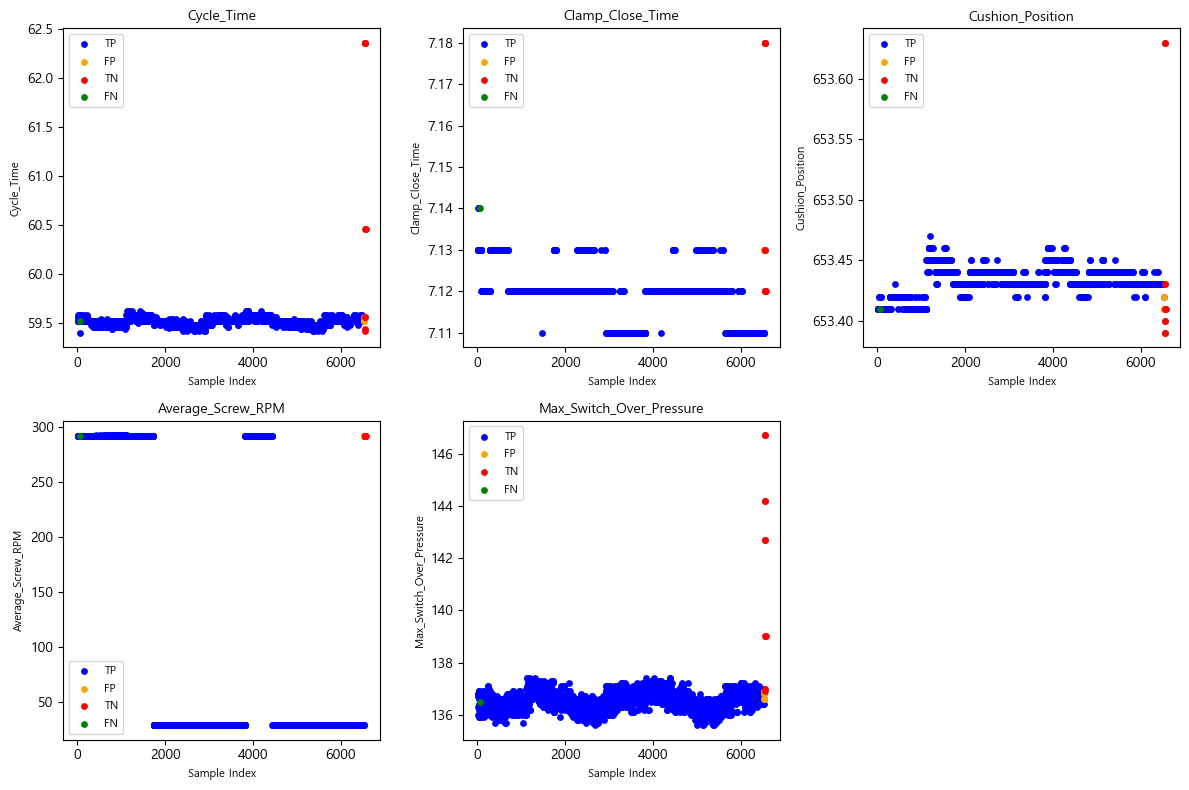

In [397]:
df = pd.DataFrame(cn7_removed_temp3)

# 독립변수 종속변수 분리 
y = cn7_removed_temp3["PassOrFail"]
X = cn7_removed_temp3.drop(columns=["PassOrFail"])


# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled=ss.transform(X_test)

model = ExtraTreesClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
# 혼돈 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 각 샘플에 대해 TN/FP/FN/TP 할당 함수 정의
def assign_confusion_category(y_true, y_pred):
    categories = []
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label == 0 and pred_label == 0:
            categories.append("TN") # True Negative
        elif true_label == 0 and pred_label == 1:
            categories.append("FP") # False Positive
        elif true_label == 1 and pred_label == 0:
            categories.append("FN") # False Negative
        elif true_label == 1 and pred_label == 1:
            categories.append("TP") # True Positive
    return categories

# 카테고리 할당
categories = assign_confusion_category(y_test.values, y_pred)

# 테스트 데이터에 카테고리 추가
X_test_with_categories = X_test.copy()
X_test_with_categories["Category"] = categories

# TN/FP/FN/TP 개수 계산
category_counts = pd.Series(categories).value_counts()

# 결과 출력 (카테고리 개수)
print("Confusion Matrix Category Counts:")
print(category_counts)

# 산점도 시각화
plt.figure(figsize=(12, 8))
colors = {"TP": "blue", "FP": "orange", "TN": "red", "FN": "green"}

for i, column in enumerate(X_test.columns):
    plt.subplot(2, int(np.ceil(len(X_test.columns) / 2)), i + 1)
    for category in colors.keys():
        subset = X_test_with_categories[X_test_with_categories["Category"] == category]
        plt.scatter(
            subset.index,
            subset[column],
            label=category,
            color=colors[category],
            s=15 # 점 크기 조정 (작게 설정)
        )
    plt.title(f"{column}", fontsize=10) # 제목 글씨 크기 조정
    plt.xlabel("Sample Index", fontsize=8) # x축 글씨 크기 조정
    plt.ylabel(column, fontsize=8) # y축 글씨 크기 조정
    plt.legend(fontsize=8) # 범례 글씨 크기 조정

plt.tight_layout()
plt.show()

In [400]:
cn7_removed_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6573 entries, 0 to 6572
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassOrFail                6573 non-null   int64  
 1   Injection_Time            6573 non-null   float64
 2   Cycle_Time                6573 non-null   float64
 3   Clamp_Close_Time          6573 non-null   float64
 4   Cushion_Position          6573 non-null   float64
 5   Plasticizing_Position     6573 non-null   float64
 6   Average_Screw_RPM         6573 non-null   float64
 7   Max_Switch_Over_Pressure  6573 non-null   float64
 8   Hopper_Temperature        6573 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 462.3 KB


In [405]:
y = cn7_removed_temp["PassOrFail"]
X = cn7_removed_temp.drop(columns=["PassOrFail"])

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled=ss.transform(X_test)

model = ExtraTreesClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50)
model.fit(X_train_scaled, y_train)

ExtraTreesClassifier(max_depth=20, min_samples_split=5, n_estimators=50)

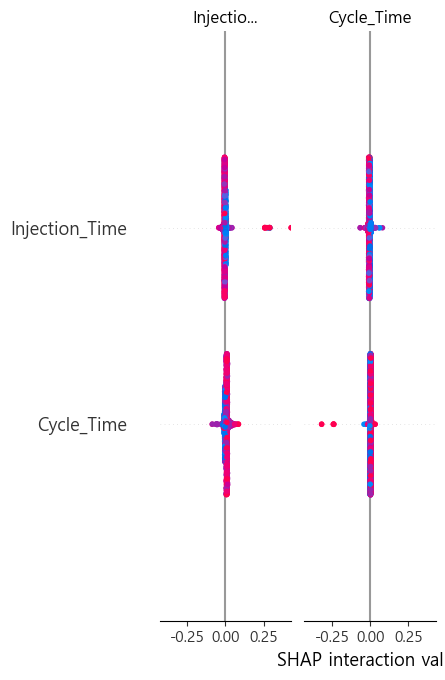

In [406]:
import shap
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_train_scaled,  check_additivity=False)

# X_train_scaled를 DataFrame으로 변환
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# SHAP 요약 플롯 생성
shap.summary_plot(shap_values, X_train_scaled_df)

In [403]:
import shap
import pandas as pd

# 정규화된 데이터를 DataFrame으로 변환 (원래 독립변수 명 사용)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# SHAP Explainer 생성 및 SHAP 값 계산 (additivity 검증 비활성화)
explainer = shap.Explainer(model, X_train_scaled_df)
shap_values = explainer(X_train_scaled_df, check_additivity=False)

# 하나의 샘플 선택 (예: 인덱스 0)
sample_idx = 1

# 선택한 샘플에 대한 SHAP 값을 waterfall 플롯으로 시각화
shap.plots.waterfall(shap_values[sample_idx])

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (8, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [404]:
import numpy as np
import pandas as pd

# SHAP 값은 explainer 호출 후 shap_values 객체에 저장됩니다.
# 각 피처의 평균 절대 기여도를 계산합니다.
mean_abs_shap = np.mean(np.abs(shap_values.values), axis=0)

# DataFrame으로 정리하여 피처명과 함께 보기 좋게 구성합니다.
shap_importance_df = pd.DataFrame({
    'Feature': X_train_scaled_df.columns,
    'Mean_Absolute_SHAP': mean_abs_shap
})

# 평균 절대 SHAP 값 기준 내림차순 정렬
shap_importance_df.sort_values('Mean_Absolute_SHAP', ascending=False, inplace=True)
print(shap_importance_df)

ValueError: Per-column arrays must each be 1-dimensional